### Import useful libraries and helpers

In [20]:
%run "Imports.ipynb"
%run "Helpers.ipynb"

### Load the data

In [6]:
df_all = pd.read_pickle("df_all.pkl")

### Have a look at each city zone separately

In [63]:
# [0,9] [1,9] [2,9] ... [7,9] [8,9] [9,9]
# .......................................
# [0,2] [1,2] [2,2] ... [7,2] [8,2] [9,2]
# [0,1] [1,1] [2,1] ... [7,1] [8,1] [9,1]
# [0,0] [1,0] [2,0] ... [7,0] [8,0] [9,0]

In [7]:
zone_names = df_all['zone'].unique()

In [8]:
# Create a data frame dictionary to store zone data frames
DataFrameDict = {elem : pd.DataFrame for elem in zone_names}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_all[:][df_all.zone == key]

In [9]:
DataFrameDict['0_0_10_10'].head()

,Unnamed: 0,zone,timestamp,supply,forecast,date,time,new_year,new_year_week,epiphany,...,other,temperature_max,temperature_min,rain,sat_or_sun,holidays,holidays_week,x_coordinate,y_coordinate,weekday
0,0,0_0_10_10,2019-01-04 14:00:00,1,NaN,2019-01-04,14:00:00,0,0.5,0,...,0,0.0,-6.666667,0.508,0,0,0.5,0,0,Friday
1,1,0_0_10_10,2019-01-04 15:00:00,0,NaN,2019-01-04,15:00:00,0,0.5,0,...,0,0.0,-6.666667,0.508,0,0,0.5,0,0,Friday
2,2,0_0_10_10,2019-01-04 16:00:00,0,NaN,2019-01-04,16:00:00,0,0.5,0,...,0,0.0,-6.666667,0.508,0,0,0.5,0,0,Friday
3,3,0_0_10_10,2019-01-04 17:00:00,0,NaN,2019-01-04,17:00:00,0,0.5,0,...,0,0.0,-6.666667,0.508,0,0,0.5,0,0,Friday
4,4,0_0_10_10,2019-01-04 18:00:00,0,NaN,2019-01-04,18:00:00,0,0.5,0,...,0,0.0,-6.666667,0.508,0,0,0.5,0,0,Friday


### Naive prediction

In [21]:
naive_forecast = calculate_naive_forecast(DataFrameDict, '2020-01-31 00:00:00')

In [22]:
naive_xyz = prepare_xyz(naive_forecast)

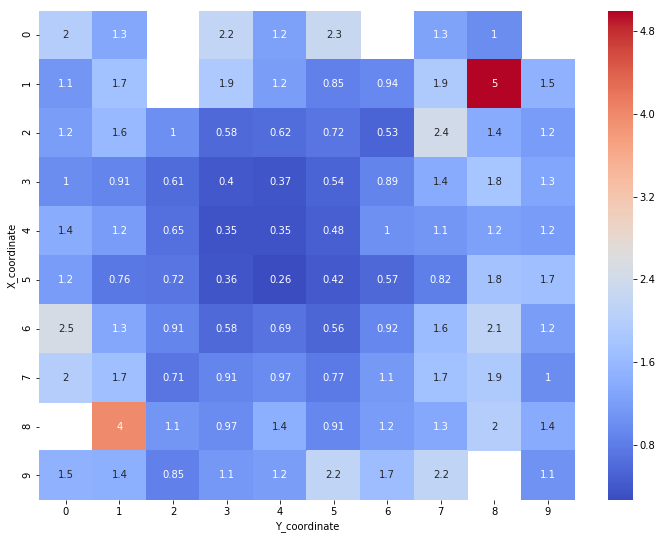

In [23]:
plot_heatmap(*naive_xyz)

### Prophet prediction

In [27]:
prophet_forecast = calculate_prophet_forecast(DataFrameDict, '2020-01-31 00:00:00')

In [25]:
prophet_xyz = prepare_xyz(prophet_forecast)

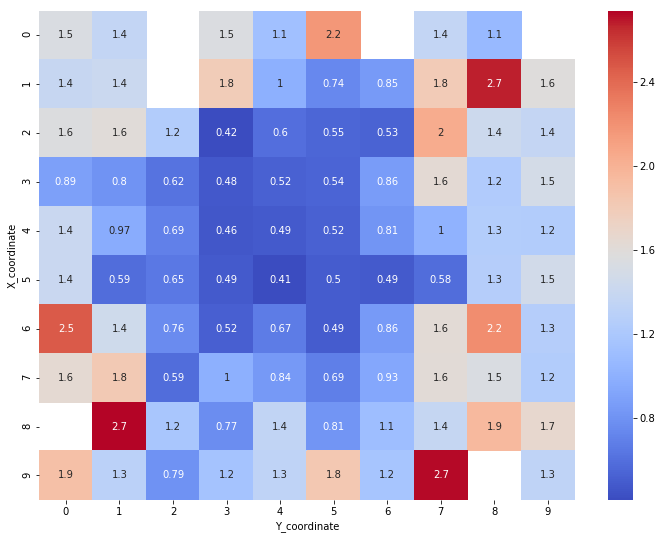

In [26]:
plot_heatmap(*prophet_xyz)

#### Prophet analysis of single zone

In [144]:
zone_5_4_data = DataFrameDict['5_4_10_10'][['timestamp','supply']]

In [120]:
zone_5_4_data.columns = ['ds','y']

zone_5_4_data = zone_5_4_data.sort_values(by=['ds'])

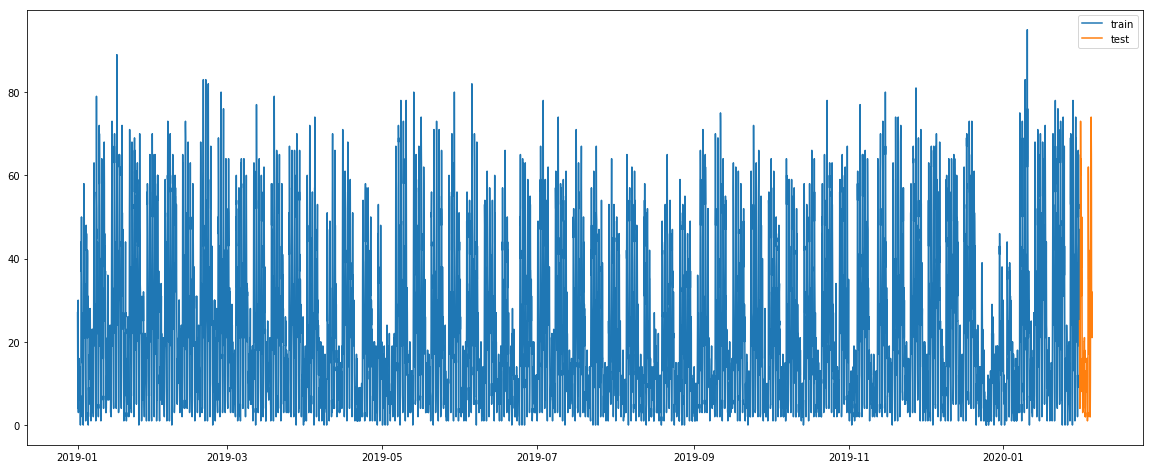

In [121]:
# cut_date = '2019-12-31 00:00:00'
cut_date = '2020-01-31 00:00:00'
train = zone_5_4_data[ zone_5_4_data.ds < cut_date ]
test = zone_5_4_data[ zone_5_4_data.ds >= cut_date ]

plt.figure(figsize=(20,8))
plt.plot( train.ds, train.y, label='train' )
plt.plot( test.ds, test.y, label='test' )
plt.legend()

In [122]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='H', include_history=False)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


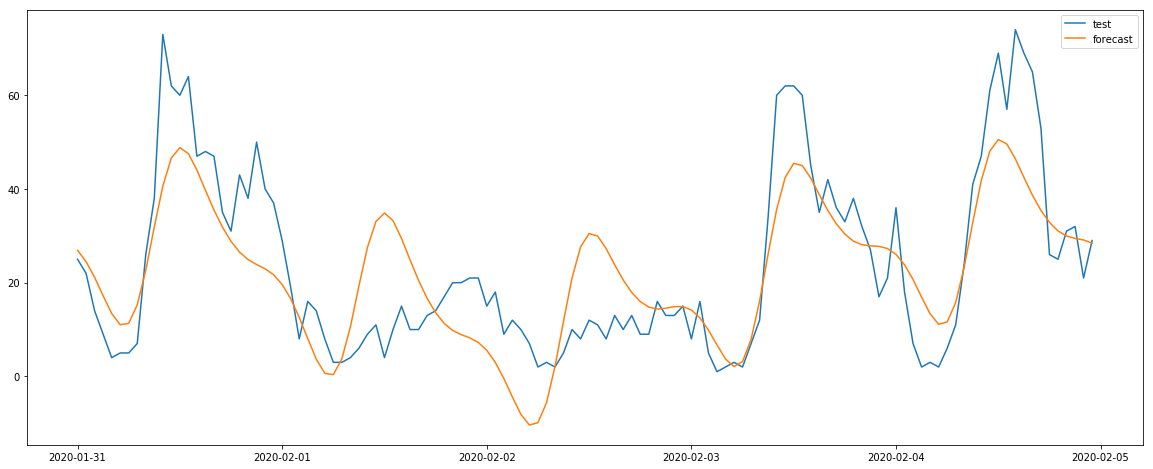

In [123]:
plt.figure(figsize=(20,8))
plt.plot( test.ds, test.y, label='test' )
plt.plot( test.ds, forecast.yhat, label='forecast' )

plt.legend()

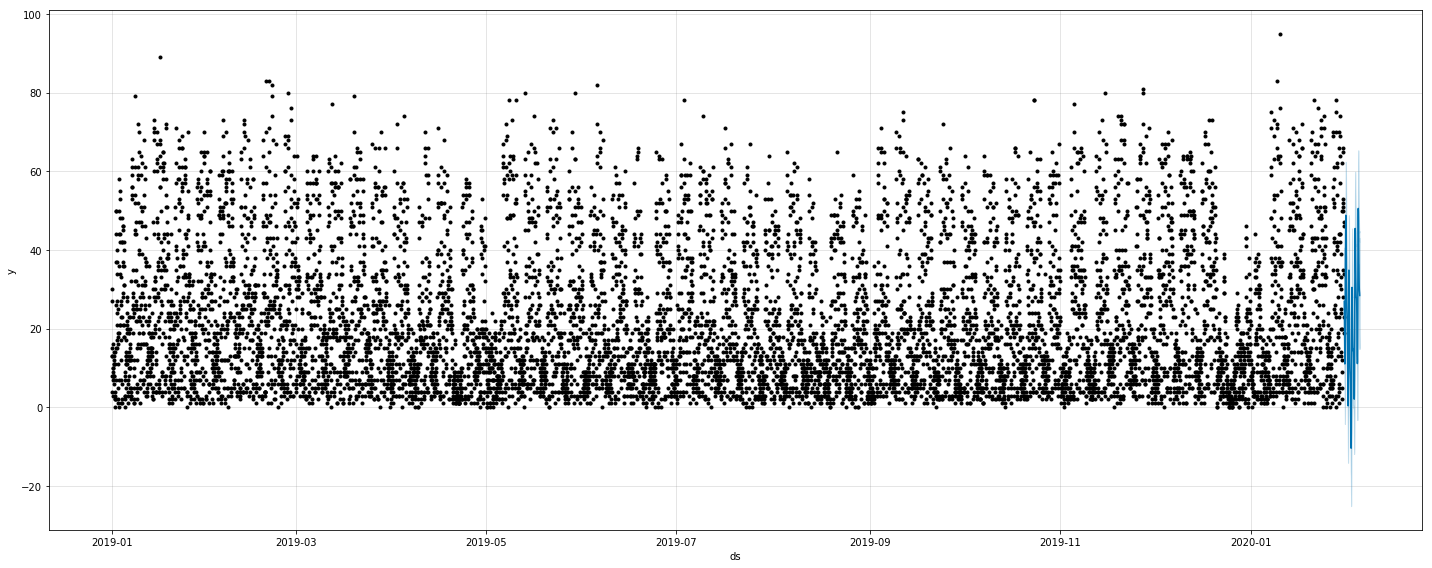

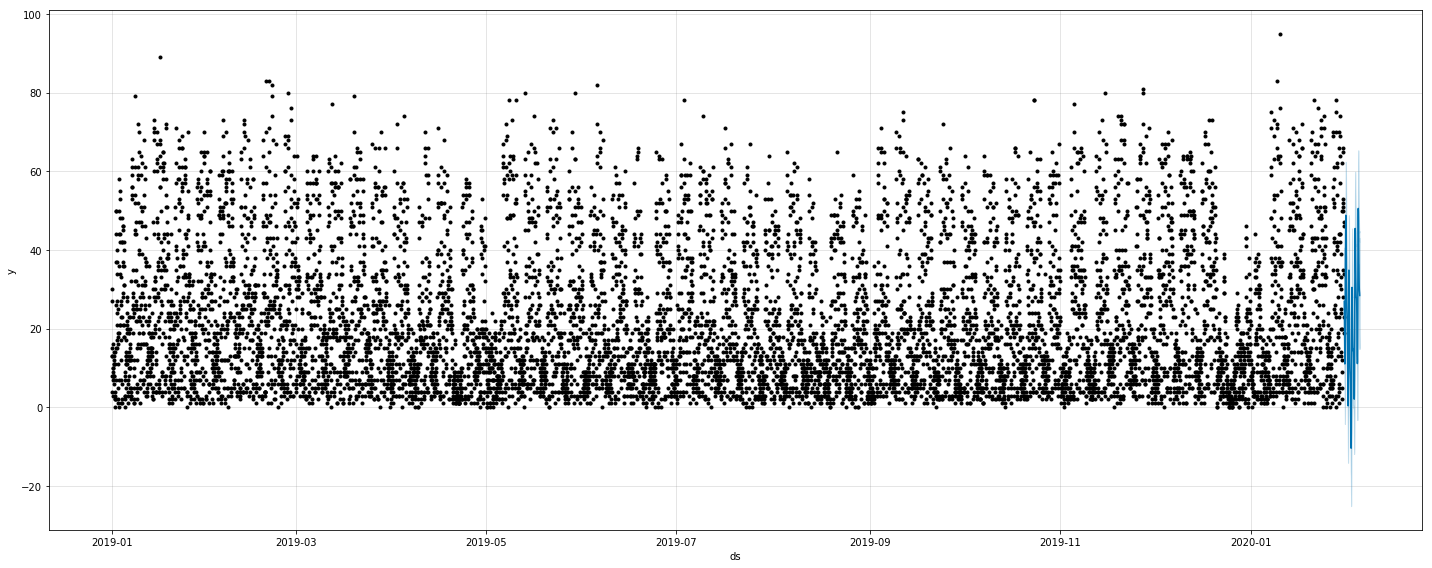

In [124]:
plot(m, forecast, figsize=(20,8))

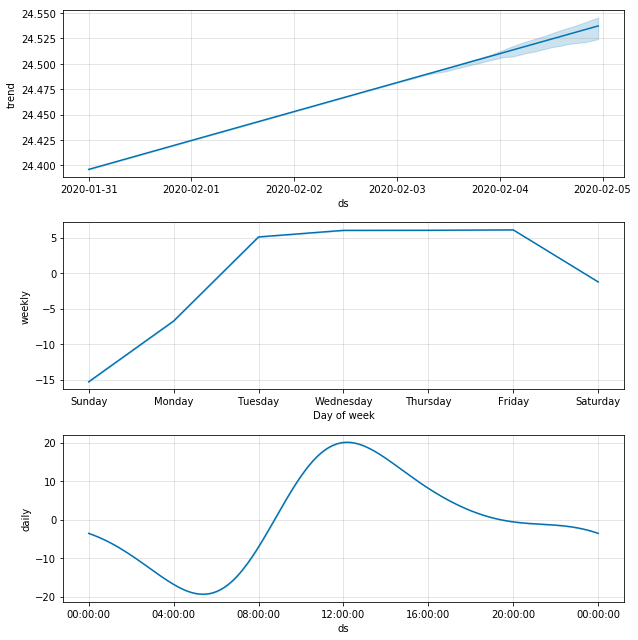

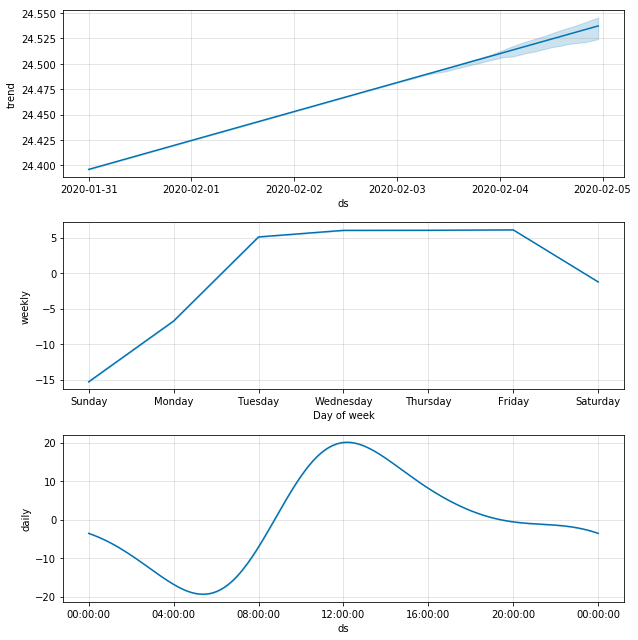

In [125]:
m.plot_components(forecast)

In [126]:
success_metric(test.y.values,forecast.yhat.values)

0.4093735277

### Compare Prophet and naive prediction results

In [127]:
z_naive = naive_xyz[2]

In [128]:
z_prophet = prophet_xyz[2]

In [129]:
diff = z_naive - z_prophet

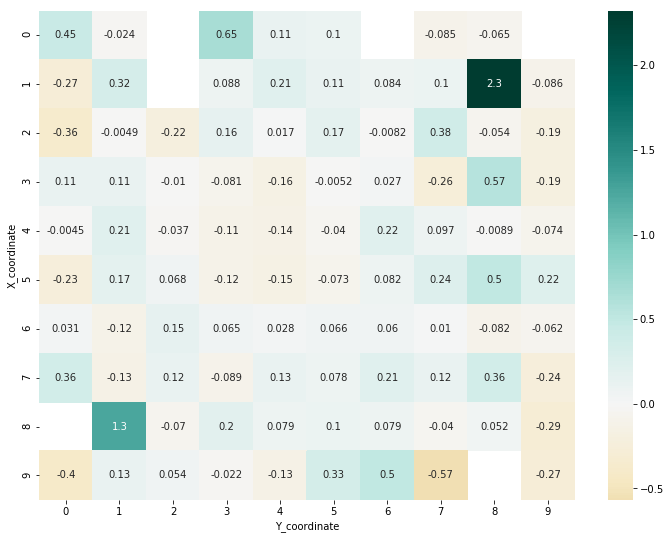

In [130]:
plot_comparison_heatmap(naive_xyz[0],naive_xyz[1],diff,center=0.00,cmap="BrBG")

In [132]:
diff.sum()

6.902005530299999

### Attempt to improve Prophet prediction

In [216]:
m = Prophet(growth="linear",holidays_prior_scale=10,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)
m.add_country_holidays(country_name='PL'
                      ).add_seasonality(name='monthly', period=30.5, fourier_order=55
                                       ).add_seasonality(name='weekly', period=7, fourier_order=10
                                                        ).add_seasonality(name='daily', period=1, fourier_order=15) 
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='H', include_history=False)
forecast = m.predict(future)

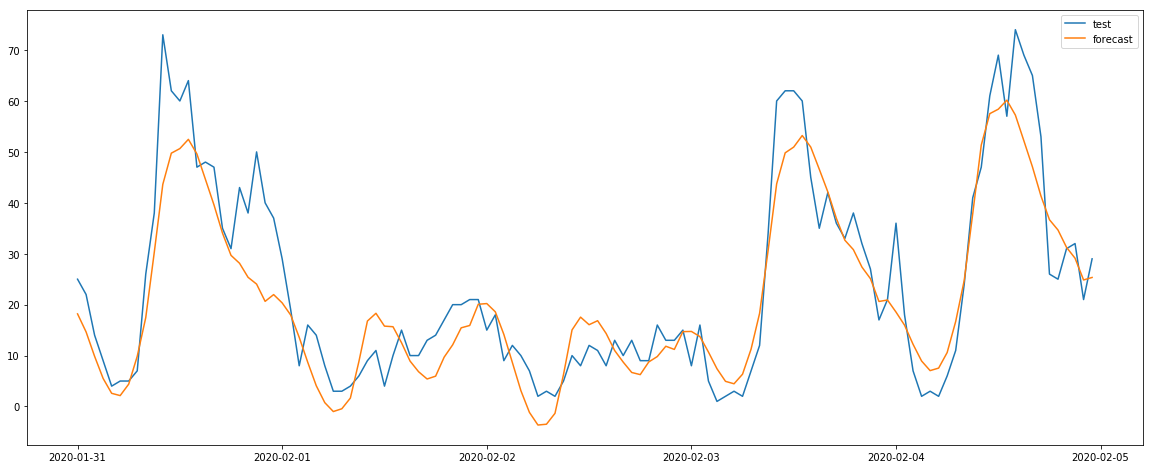

In [217]:
plt.figure(figsize=(20,8))
plt.plot( test.ds, test.y, label='test' )
plt.plot( test.ds, forecast.yhat, label='forecast' )

plt.legend()

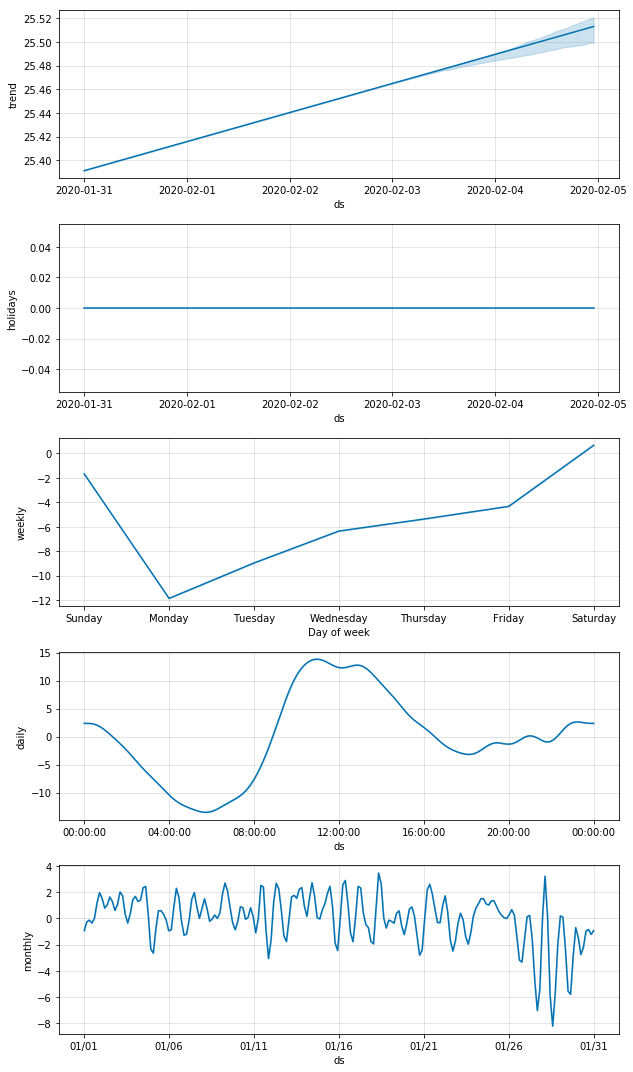

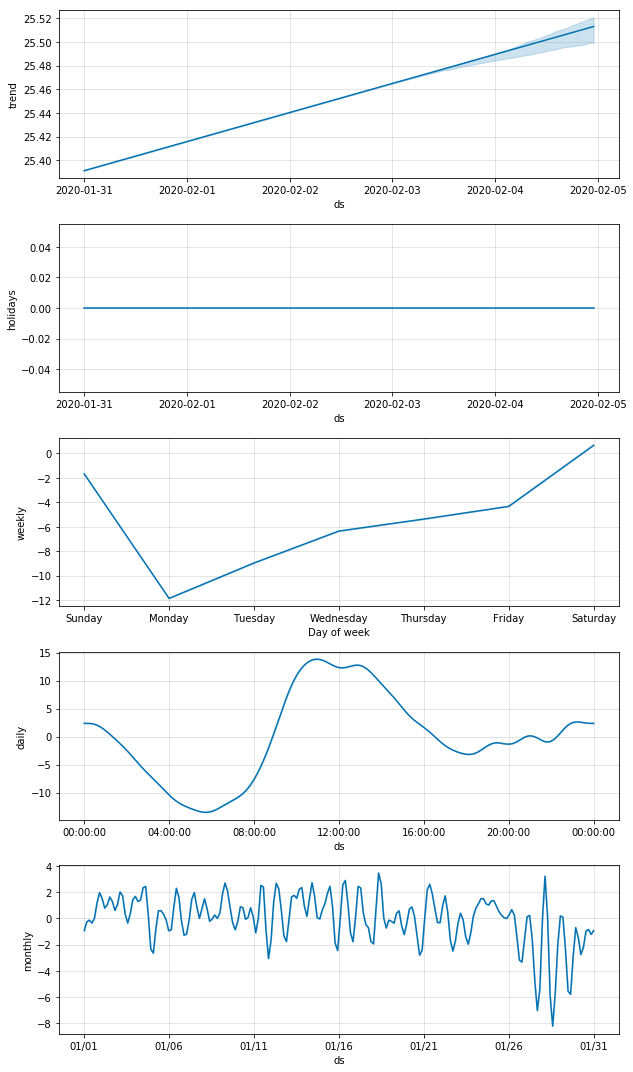

In [218]:
m.plot_components(forecast)

In [219]:
success_metric(test.y.values,forecast.yhat.values)

0.2604296468

In [10]:
improved_prophet_forecast = calculate_improved_prophet_forecast(DataFrameDict,'2020-01-31 00:00:00')

In [11]:
improved_prophet_xyz = prepare_xyz(improved_prophet_forecast)

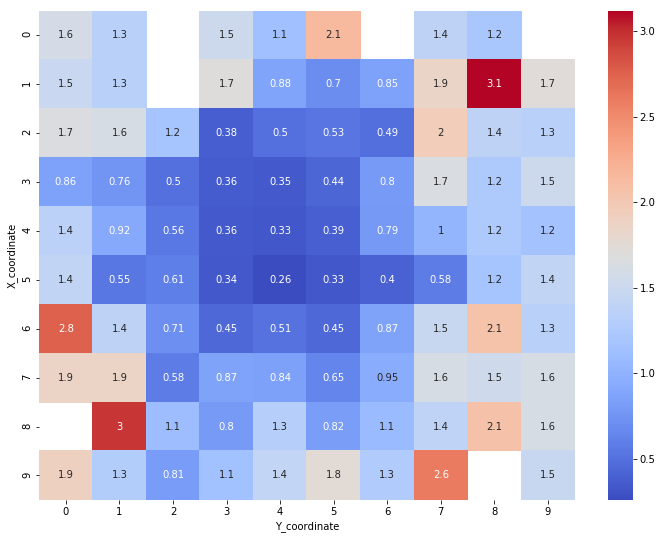

In [12]:
plot_heatmap(*improved_prophet_xyz)

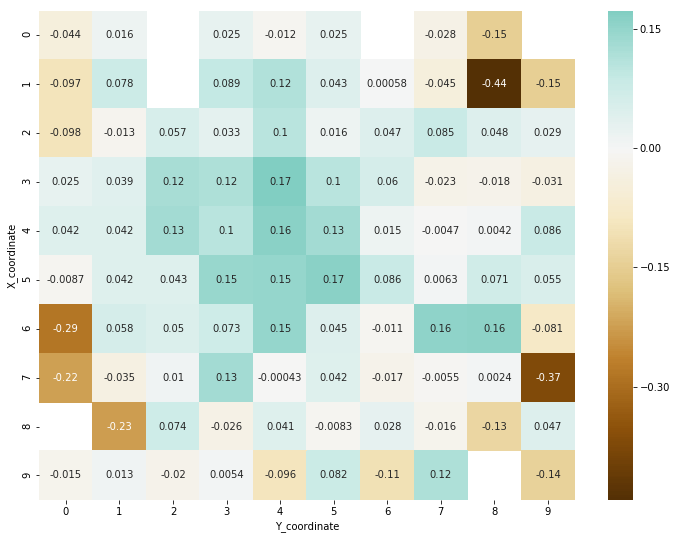

In [28]:
diff = prophet_xyz[2] - improved_prophet_xyz[2]
plot_comparison_heatmap(naive_xyz[0],naive_xyz[1],diff,center=0.00,cmap="BrBG")

In [29]:
diff.sum()

1.2600053280999999

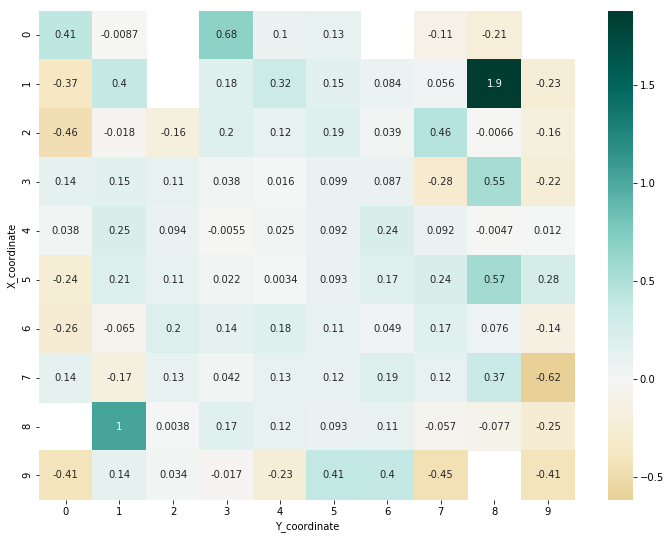

In [16]:
diff = naive_xyz[2] - improved_prophet_xyz[2]
plot_comparison_heatmap(naive_xyz[0],naive_xyz[1],diff,center=0.00,cmap="BrBG")

In [17]:
diff.sum()

8.1620108584

Adding PL holiday data did not help.
Adding monthly seasonality has helped a bit

In [213]:
print(single_zone_prophet_forecast(DataFrameDict['5_4_10_10'], '2020-01-31 00:00:00'))
print(single_zone_prophet_forecast_improved(DataFrameDict['5_4_10_10'], '2020-01-31 00:00:00'))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


0.4093735277
0.2614238687


In [201]:
print(single_zone_prophet_forecast(DataFrameDict['5_4_10_10'], '2019-12-31 00:00:00'))
print(single_zone_prophet_forecast_improved(DataFrameDict['5_4_10_10'], '2019-12-31 00:00:00'))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


0.4277932582
0.2787749167


In [202]:
print(single_zone_prophet_forecast(DataFrameDict['5_4_10_10'], '2019-11-30 00:00:00'))
print(single_zone_prophet_forecast_improved(DataFrameDict['5_4_10_10'], '2019-11-30 00:00:00'))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


0.4704893565
0.3414529698
